# What are the demographic characteristics of neighborhoods where entitlements are?

In [1]:
import intake
import IPython.display
import matplotlib.pyplot as plt
import pandas

cat = intake.open_catalog("../catalogs/*.yml")

## PCTS

First, we load the PCTS extract and associated data into our session:

In [2]:
pcts = cat.pcts2.read()

In [3]:
# ACS data for income, race, commute, tenure
census = pandas.read_parquet(
    "s3://city-planning-entitlements/data/final/census_cleaned.parquet"
)

In [4]:
# Census tracts
tracts = cat.census_tracts.read()
tracts = tracts.assign(
    density=tracts.HD01_VD01.astype(int)/(tracts.Shape_STAr/5280./5280.),
    population=tracts.HD01_VD01,
)

In [5]:
parcel_to_tract = pandas.read_parquet(
    "s3://city-planning-entitlements/data/crosswalk_parcels_tracts.parquet"
)

The requested entitlements are in the suffixes of the PCTS case number.
A given case can have an arbitrary number of entitlement suffixes, so
we need to parse it into its component parts.
We can use a regex for that:

In [6]:
from utils import GENERAL_PCTS_RE
display(GENERAL_PCTS_RE)
cols = pcts.CASE_NBR.str.extract(GENERAL_PCTS_RE)

re.compile(r'([A-Z]+)-([0-9X]{4})-([0-9]+)((?:-[A-Z0-9]+)*)$', re.UNICODE)

In [7]:
all_suffixes = cols[3].str.strip("-").str.split("-", expand=True)

In [8]:
suffix_counts = (all_suffixes
    .apply(lambda col: col.value_counts(), axis=0)
    .sum(axis=1)
    .astype(int)
    .sort_values(ascending=False)
)
suffix_counts.to_frame("Count").head(40)

,Count
EIR,95944
CPU,86187
CE,33071
GPA,21405
CA,18160
VSO,15420
CRA,10219
SP,9833
ZC,9762
MEL,7960


Associate each PCTS entitlement case with a census tract:

In [9]:
pcts = pcts.merge(
    parcel_to_tract[["GEOID", "AIN"]],
    how="left",
    on="AIN",
).merge(
    tracts[["GEOID10", "population", "density"]],
    how="left",
    left_on="GEOID",
    right_on="GEOID10",
)

In [10]:
pcts_suffixes = pandas.concat((pcts, all_suffixes), axis=1)

Each case can have multiple suffixes. However, it is useful
to be able to refer to a single suffix column when performing
aggregations and computing statistics.
Here we melt the suffix columns into a single column.
This has the effect of creating multiple rows for cases
that have multiple entitlements being requested.

In [11]:
pcts_suffixes = pcts_suffixes.melt(
    id_vars=pcts.columns,
    var_name="nothing",
    value_name="suffix"
).dropna(subset=["suffix"]).drop(columns=["GEOID10", "nothing"])

In [12]:
pcts_suffixes.head()

,CASE_ID,APLC_ID,CASE_NBR,CASE_SEQ_NBR,CASE_YR_NBR,CASE_ACTION_ID,CASE_FILE_RCV_DT,CASE_FILE_DATE,PARNT_CASE_ID,PARENT_CASE,AIN,PROJ_DESC_TXT,id,GEOID,population,density,suffix
0,193546.0,118838.0,ZA-2013-3079-CEX,3079.0,2013.0,1.0,2013-10-03 00:00:00,2013-10,NaN,193546.0,4420030014,COASTAL EXEMPTION TO ALLOW THE ADDITION OF 275...,3079_2013,06037262604,6232,2856.891649,CEX
1,234299.0,192286.0,CPC-2019-7393-CA,7393.0,2019.0,NaN,2019-12-11 15:06:32,2019-12,NaN,234299.0,4420030014,CODE AMENDMENT,7393_2019,06037262604,6232,2856.891649,CA
2,193547.0,118839.0,AA-2013-3080-PMLA-SL,3080.0,2013.0,2.0,2013-10-03 00:00:00,2013-10,NaN,193547.0,5594004009,PRELIMINARY PARCEL MAP SMALL LOT NEW 3 TWO STO...,3080_2013,06037188100,4147,5054.886536,PMLA
3,193548.0,118839.0,ENV-2013-3081-MND,3081.0,2013.0,NaN,2013-10-03 00:00:00,2013-10,NaN,193548.0,5594004009,PRELIMINARY PARCEL MAP SMALL LOT NEW 3 TWO STO...,3081_2013,06037188100,4147,5054.886536,MND
4,193549.0,118839.0,ZA-2013-3082-ZAA,3082.0,2013.0,2.0,2013-10-03 00:00:00,2013-10,NaN,193549.0,5594004009,PRELIMINARY PARCEL MAP SMALL LOT NEW 3 TWO STO...,3082_2013,06037188100,4147,5054.886536,ZAA


Our first pass at analyzing entitlements is to count the number
of cases for each census tract, to see which kinds of entitlements
are being applied for in which types of census tract:

In [13]:
entitlement = (pcts_suffixes
    .groupby(["GEOID", "suffix"])
    .size()
    .to_frame("count")
).reset_index(level=1)

We next calculate incomes on a census tract level.
We pivot the `new_var` column into wide format to get a column for each variable.

In [14]:
income = census[(census.table == "incomerange") & (census.year == 2018)]
income = income.pivot(index="GEOID", columns="new_var", values="num")

Merge the income data with the entitlements counts:

In [15]:
joined = pandas.merge(
    income,
    entitlement,
    how="inner",
    left_index=True,
    right_index=True,
)

We'd like to calculate income percentiles from the reported ranges.
The following function takes a row from the pivoted ACS data,
and estimates a set of percentiles from the binned data:

In [16]:
def income_percentiles(row, percentiles, prefix="total"):
    # Edges of the reported income bins, in thousands of dollars
    bins = [0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 200]
    # Iterator over percentiles
    p_it = iter(percentiles)
    # Final values for percentiles
    values = []
    # Initialize current percentile and an accumulator variable
    curr = next(p_it)
    acc = 0
    # The total count for the tract
    total = row[f"{prefix}_total"]
    if total <= 0:
        return values
    for i, b in enumerate(bins):
        # Compute the label of the current bin
        if i == 0:
            label = f"{prefix}_lt{bins[i+1]}"
        elif i == len(bins) - 1:
            label = f"{prefix}_gt{b}"
        else:
            label = f"{prefix}_r{b}to{bins[i+1]-1}"
        # Estimate the value for the current percentile
        # if it falls within this bin
        while (acc + row[label])/total > curr/100.0:
            frac = (total*curr/100.0 - acc)/row[label]
            lower = b
            upper = bins[i+1] if i < (len(bins) - 1) else 300. 
            interp = (1.0 - frac) * lower + frac * upper
            values.append(interp)
            try:
                curr = next(p_it)
            except StopIteration:
                return values
        # Increment the accumulator
        acc = acc + row[label]
    return values

Compute the inter-quartile range for the income data:

In [17]:
iqr = joined.apply(
    lambda r: pandas.Series(income_percentiles(r, [25,50,75]), dtype="float64"),
    axis=1,
).rename(columns={0: "Q1", 1: "Q2", 2: "Q3"})

In [18]:
joined = pandas.concat((joined, iqr), axis=1)[["Q1", "Q2", "Q3", "suffix", "count"]]
# Bring in population density
joined = joined.reset_index().merge(
    tracts[["GEOID10", "density"]],
    how="left",
    left_on="GEOID",
    right_on="GEOID10",
).drop(columns="GEOID10").set_index("GEOID").dropna()

Plot entitlement stats against median household income,
population density, and geography:

In [19]:
def plot_entitlement(df, tracts, suffix):

    tpl = joined[joined["count"] > 0][joined.suffix == suffix]
    
    fig = plt.figure(figsize=(12,8))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
    ax1.set_xlabel("Median income")
    ax1.set_ylabel("Entitlement count")
    ax1.scatter(tpl.Q2, tpl["count"])

    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
    ax2.set_xlabel("Population density")
    ax2.set_ylabel("Entitlement count")
    ax2.scatter(tpl.density, tpl["count"])

    ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
    ax3.axis("off")
    tracts.merge(
        tpl,
        left_on="GEOID10",
        right_index=True,
        how="left"
    ).fillna(
        {"count": 0}
    ).plot(
        ax=ax3,
        column="count",
        cmap="magma",
    )
    plt.close() # Prevent double plotting
    return fig

Dropdown(options=(('EIR (95944)', 'EIR'), ('CPU (86187)', 'CPU'), ('CE (33071)', 'CE'), ('GPA (21405)', 'GPA')…

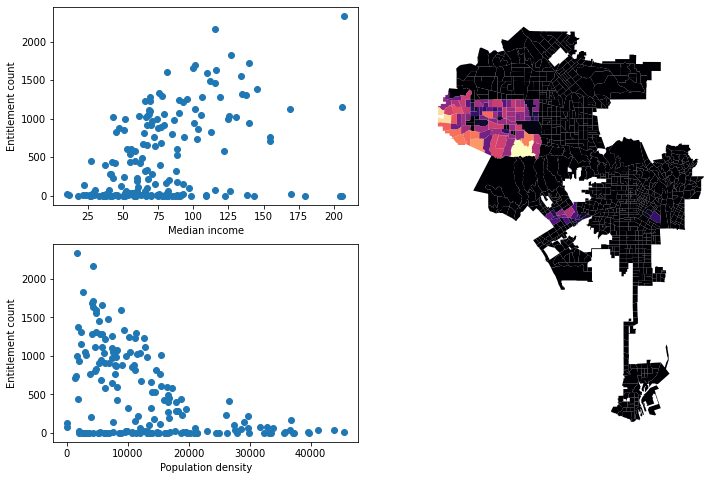

In [43]:
import ipywidgets

dropdown = ipywidgets.Dropdown(
    options=[
        (f"{name} ({count})", name) for name,count in zip(suffix_counts.index, suffix_counts)
    ]
)
    
display(dropdown)
disp = display(plot_entitlement(joined, tracts, "TOC"), display_id=True)

def on_selection(*args):
    disp.update(plot_entitlement(joined, tracts, dropdown.value))

dropdown.observe(on_selection, names="value")
